In [1]:
### Import packages ###
import os
import re
import json
import pickle
import argparse
import numpy as np
import pandas as pd

# Input Datatype

In [5]:
DataTypeInput = "COMPAS"
PredictorTypeInput = "TreeFARMS"

In [ ]:
PassiveLearning_MTTreeFarmsRashomonNum11.pkl
RashomonQBC_MTTreeFarmsRashomonNum11.pkl
RashomonQBC_MTTreeFarmsRashomonNum1010.pkl
RashomonQBC_MTTreeFarmsRashomonNum100100.pkl

In [7]:
### Set Up  ###
cwd = os.getcwd()
ResultsDirectory = os.path.join(cwd, "Results",DataTypeInput, PredictorTypeInput)
SaveDirectory = os.path.join(ResultsDirectory, "ProcessedResults")
AllSelectorMethodErrors = {selector: [] for selector in json.loads(args.SelectorType)}

#### Construct Directory ###
Directory = os.path.join(ResultsDirectory, "Raw")


NameError: name 'args' is not defined

In [14]:
import os
import pickle
import numpy as np

# File path list
file_paths = "/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/Raw"


# Categories to group files
categories = {
    "PassiveLearning_MTTreeFarmsRashomonNum11": [],
    "RashomonQBC_MTTreeFarmsRashomonNum11": [],
    "RashomonQBC_MTTreeFarmsRashomonNum1010": [],
    "RashomonQBC_MTTreeFarmsRashomonNum100100": [],
}

# Group files into categories
for path in file_paths:
    for category in categories:
        if category in path:
            categories[category].append(path)

# Function to extract ErrorVecs for a category
def extract_errorvecs(file_list):
    error_vecs = []
    for file in file_list:
        with open(file, 'rb') as f:
            data = pickle.load(f)
            error_vecs.append(data['ErrorVec'])
    return np.column_stack(error_vecs)  # Combine columns to form N x 10 matrix

# Extract matrices for each category
result_matrices = {}
for category, files in categories.items():
    result_matrices[category] = extract_errorvecs(files)

# Result is a dictionary with category names as keys and N x 10 matrices as values


ValueError: need at least one array to concatenate

In [15]:
import os
import shutil
import pickle
import numpy as np

# Define the base directory containing the files
base_dir = "/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/Raw"

# Define the categories based on file endings
categories = [
    "PassiveLearning_MTTreeFarmsRashomonNum11.pkl",
    "RashomonQBC_MTTreeFarmsRashomonNum11.pkl",
    "RashomonQBC_MTTreeFarmsRashomonNum1010.pkl",
    "RashomonQBC_MTTreeFarmsRashomonNum100100.pkl",
]

# Create directories for each category
for category in categories:
    category_dir = os.path.join(base_dir, category.split(".")[0])  # Strip '.pkl' for directory name
    os.makedirs(category_dir, exist_ok=True)

# Move files into category directories
for filename in os.listdir(base_dir):
    if filename.endswith(".pkl"):
        for category in categories:
            if filename.endswith(category):
                src = os.path.join(base_dir, filename)
                dest = os.path.join(base_dir, category.split(".")[0], filename)
                shutil.move(src, dest)
                print(f"Moved: {filename} -> {dest}")
                break

# Function to extract error vectors
def extract_errorvecs(file_list):
    error_vecs = []
    for file_path in file_list:
        try:
            with open(file_path, "rb") as f:
                data = pickle.load(f)
                if 'ErrorVec' in data:
                    error_vecs.append(data['ErrorVec'])
                else:
                    print(f"Key 'ErrorVec' not found in {file_path}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    if error_vecs:
        return np.column_stack(error_vecs)
    else:
        print("No valid ErrorVec data found.")
        return np.array([])

# Collect files and process them
result_matrices = {}
for category in categories:
    category_dir = os.path.join(base_dir, category.split(".")[0])
    category_files = [os.path.join(category_dir, file) for file in os.listdir(category_dir) if file.endswith(".pkl")]
    print(f"Processing category: {category} with {len(category_files)} files")
    result_matrices[category] = extract_errorvecs(category_files)

# Check results
for category, matrix in result_matrices.items():
    print(f"Category: {category}, Matrix shape: {matrix.shape}")


Processing category: PassiveLearning_MTTreeFarmsRashomonNum11.pkl with 10 files
Processing category: RashomonQBC_MTTreeFarmsRashomonNum11.pkl with 10 files
Processing category: RashomonQBC_MTTreeFarmsRashomonNum1010.pkl with 10 files
Processing category: RashomonQBC_MTTreeFarmsRashomonNum100100.pkl with 10 files
Category: PassiveLearning_MTTreeFarmsRashomonNum11.pkl, Matrix shape: (4420, 10)
Category: RashomonQBC_MTTreeFarmsRashomonNum11.pkl, Matrix shape: (4420, 10)
Category: RashomonQBC_MTTreeFarmsRashomonNum1010.pkl, Matrix shape: (4420, 10)
Category: RashomonQBC_MTTreeFarmsRashomonNum100100.pkl, Matrix shape: (4420, 10)


(<Figure size 700x600 with 1 Axes>, <Figure size 700x600 with 1 Axes>)

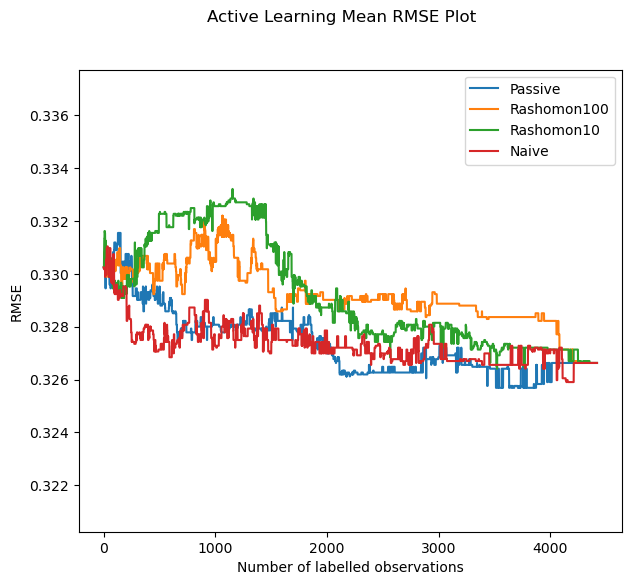

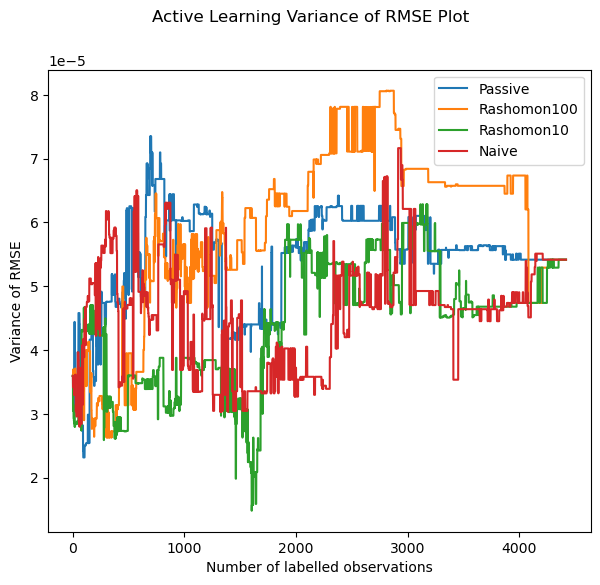

In [67]:
Rashomon100Results = pd.read_csv("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/ProcessedResults/Rashomon100.csv")
Rashomon1Results = pd.read_csv("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/ProcessedResults/Rashomon1.csv")
Rashomon10Results = pd.read_csv("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/ProcessedResults/Rashomon10.csv")
PassiveResults = pd.read_csv("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/ProcessedResults/Passive.csv")

MeanVariancePlot(Subtitle = None,
                     TransparencyVal = 0,
                     CriticalValue = 1.96,
                     RelativeRMSE = None,
                     Passive = PassiveResults,
                     Rashomon100 = Rashomon100Results,
                     Rashomon10 = Rashomon10Results,
                     Naive = Rashomon1Results)